This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Recipe #1: Clutter and attenuation correction plus composition for two DWD radars

This recipe shows a workflow to process radar data provided by the German Weather Service (DWD). The processing includes: 

- *(1)* Reading local [DX-Data](../fileio/legacy/read_dx.ipynb) for radars Feldberg and Tuerkheim. 
- *(2)* Clutter correction using the [Gabella filter algorithm](https://docs.wradlib.org/en/latest/classify.html). 
- *(3)* Attenuation correction using the [modified Kraemer algorithm](https://docs.wradlib.org/en/latest/atten.html). 
- *(4)* Conversion from reflectivity to rainfall using the [Z-R Conversions](https://docs.wradlib.org/en/latest/zr.html) module. 
- *(5)* Accumulation of rainfall depths over the entire event. 
- *(6)* [Composition](https://docs.wradlib.org/en/latest/comp.html) of data from both radars to a common Cartesian grid (UTM Zone 32). Composition is based on a weighted combination, using the sampling volume as a [quality criterion](https://docs.wradlib.org/en/latest/qual.html). 
- *(7)* Plotting a rainfall map using [cartesian plot](https://docs.wradlib.org/en/latest/vis.html).

In [1]:
import wradlib as wrl
import xarray as xr
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np

In [2]:
import glob
import os


def read_data(flist, site):
    """Helper function to read raw data for a list of datetimes <dtimes>"""
    dalist = []
    for f in flist:
        data, attrs = wrl.io.read_dx(f)
        dtime = dt.datetime.strptime(os.path.basename(f)[15:25], "%y%m%d%H%M")
        dalist.append(
            wrl.georef.create_xarray_dataarray(
                data,
                r=np.arange(500, data.shape[1] * 1000 + 500, 1000),
                phi=attrs["azim"],
                theta=attrs["elev"],
                site=site,
                sweep_mode="azimuth_surveillance",
            ).assign_coords(time=dtime)
        )
        ds = xr.concat(dalist, "time")
    return ds.assign_coords(elevation=ds.elevation.median("time"))


def process_polar_level_data(radarname, site):
    """Reading and processing polar level data (DX) for radar <radarname>"""
    print("Polar level processing for radar %s..." % radarname)

    # preparations for loading sample data in source directory
    files = glob.glob(
        os.path.join(
            wrl.util.get_wradlib_data_path(), f"dx/recipe1_data/raa*{radarname}*bin"
        )
    )

    if len(files) == 0:
        print(
            "WARNING: No data files found - maybe you did not extract "
            "the data from data/recipe1_data.zip?"
        )
    # loading the data (two hours of 5-minute images)
    data = read_data(files, site)
    # Clutter filter on an event base
    clmap = wrl.classify.filter_gabella(data.mean("time"), tr1=12, n_p=6, tr2=1.1)
    data_ipol = wrl.ipol.interpolate_polar(data, mask=clmap)
    # correcting for attenuation
    pia = data_ipol.wrl.atten.correct_attenuation_constrained(
        a_max=1.67e-4,
        a_min=2.33e-5,
        n_a=100,
        b_max=0.7,
        b_min=0.65,
        n_b=6,
        gate_length=1.0,
        constraints=[wrl.atten.constraint_dbz, wrl.atten.constraint_pia],
        constraint_args=[[59.0], [10.0]],
    )
    data_atten = data_ipol + pia
    # converting to precipitation depth
    R = wrl.zr.z_to_r(wrl.trafo.idecibel(data_atten), a=256, b=1.4)
    depth = wrl.trafo.r_to_depth(R, 300.0)
    depth.attrs = R.attrs
    # calculate hourly accumulation
    accum = depth.sum("time")
    accum.attrs = {
        "standard_name": "rainfall_amount",
        "long_name": "rainfall_amount",
        "short_name": "RSUM",
        "units": "mm",
    }

    return accum

In [3]:
def bbox(*args):
    """Get bounding box from a set of radar bin coordinates"""
    xy = np.array(
        [
            [
                arg.x.min().values,
                arg.x.max().values,
                arg.y.min().values,
                arg.y.max().values,
            ]
            for arg in args
        ]
    )
    xmin = xy[..., 0].min()
    xmax = xy[..., 1].max()
    ymin = xy[..., 2].min()
    ymax = xy[..., 3].max()

    return xmin, xmax, ymin, ymax

In [4]:
import zipfile
import shutil
import datetime as dt

# set timer
start = dt.datetime.now()
# unzip data
filename = wrl.util.get_wradlib_data_file("dx/recipe1_data.zip")
targetdir = wrl.util.get_wradlib_data_path() + "/dx/recipe1_data"
with zipfile.ZipFile(filename, "r") as z:
    z.extractall(targetdir)

# set scan geometry and radar coordinates
# r = np.arange(500.0, 128500.0, 1000.0)
# az = np.arange(0, 360)
tur_sitecoords = (9.7839, 48.5861, 0)
fbg_sitecoords = (8.005, 47.8744, 0)

# processing polar level radar data
#   Tuerkheim
tur_accum = process_polar_level_data("tur", site=tur_sitecoords)
#   Feldberg
fbg_accum = process_polar_level_data("fbg", site=fbg_sitecoords)

Polar level processing for radar tur...


Polar level processing for radar fbg...


In [5]:
# remove unzipped files
if os.path.exists(targetdir):
    try:
        shutil.rmtree(targetdir)
    except Exception:
        print("WARNING: Could not remove directory data/recipe1_data")

# derive UTM Zone 32 coordinates of range-bin centroids
# create osr projection using epsg number for UTM Zone 32
proj_utm = wrl.georef.epsg_to_osr(32632)

In [6]:
tur_accum = tur_accum.wrl.georef.georeference(crs=proj_utm)
fbg_accum = fbg_accum.wrl.georef.georeference(crs=proj_utm)

In [7]:
# define target grid for composition
xmin, xmax, ymin, ymax = bbox(tur_accum, fbg_accum)
x = np.linspace(xmin, xmax + 1000.0, 1000)
y = np.linspace(ymin, ymax + 1000.0, 1000)
grid_coords = wrl.util.gridaspoints(y, x)
cart = xr.Dataset(coords={"x": (["x"], x), "y": (["y"], y)})

In [8]:
# quality index
tur_pv = tur_accum.wrl.qual.pulse_volume(1000.0, 1.0)
fbg_pv = fbg_accum.wrl.qual.pulse_volume(1000.0, 1.0)

In [9]:
tur_gridded = tur_accum.wrl.comp.togrid(
    cart,
    radius=128500.0,
    center=(tur_accum.y.mean(), tur_accum.x.mean()),
    interpol=wrl.ipol.Nearest,
)
tur_quality_gridded = tur_pv.wrl.comp.togrid(
    cart,
    radius=128500.0,
    center=(tur_pv.y.mean(), tur_pv.x.mean()),
    interpol=wrl.ipol.Nearest,
)
fbg_gridded = fbg_accum.wrl.comp.togrid(
    cart,
    radius=128500.0,
    center=(fbg_accum.y.mean(), fbg_accum.x.mean()),
    interpol=wrl.ipol.Nearest,
)
fbg_quality_gridded = fbg_pv.wrl.comp.togrid(
    cart,
    radius=128500.0,
    center=(fbg_pv.y.mean(), fbg_pv.x.mean()),
    interpol=wrl.ipol.Nearest,
)

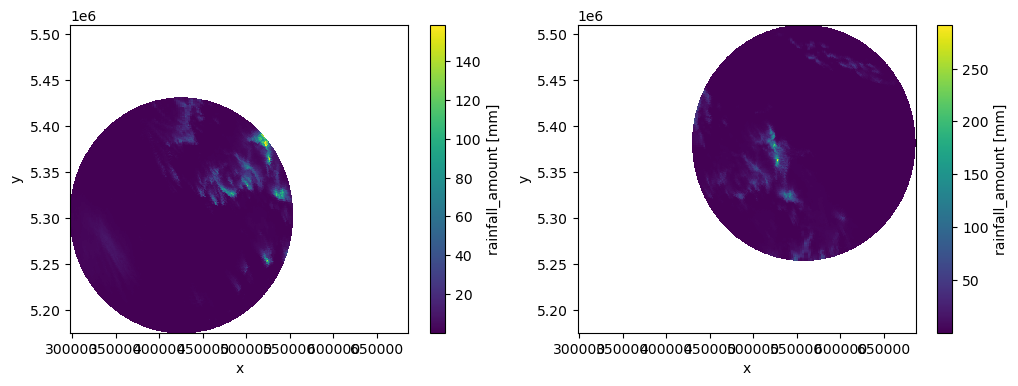

In [10]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
fbg_gridded.plot(ax=ax1)
ax2 = fig.add_subplot(122)
tur_gridded.plot(ax=ax2)

In [11]:
# compose the both radar-data based on the quality information
# calculated above
radar = xr.DataArray(["tur", "fbg"], dims="radar")
radargrids = xr.concat([tur_gridded, fbg_gridded], dim=radar)
qualitygrids = xr.concat(
    [1.0 / (tur_quality_gridded + 0.001), 1.0 / (fbg_quality_gridded + 0.001)],
    dim=radar,
)

In [12]:
print("Composing Tuerkheim and Feldbarg data on a common grid...")
composite = radargrids.wrl.comp.compose_weighted(qualitygrids)

print("Processing took:", dt.datetime.now() - start)

Composing Tuerkheim and Feldbarg data on a common grid...
Processing took: 0:00:08.068456


(5175389.476956294, 5510145.114252917)

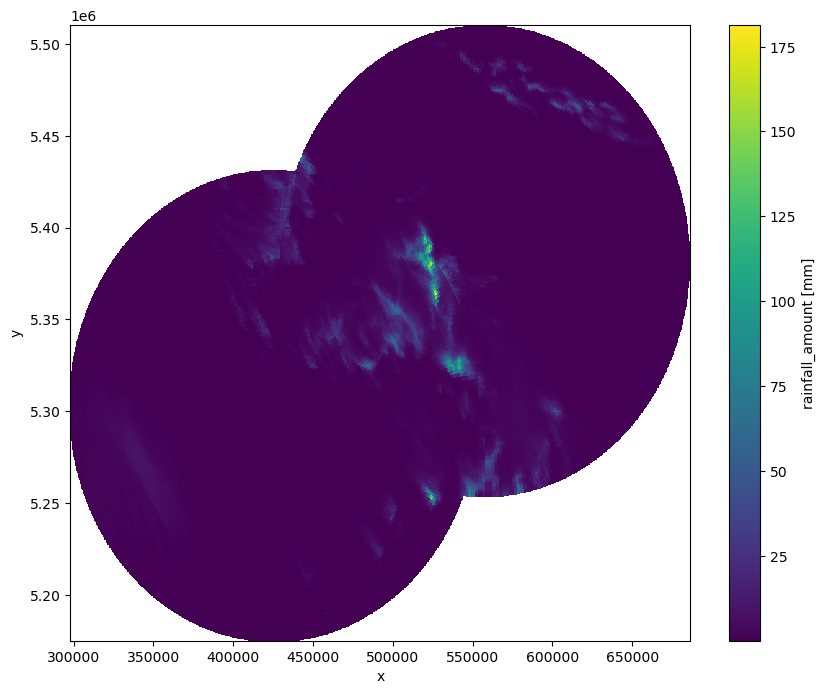

In [13]:
# Plotting rainfall map
plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect="equal")
composite.plot(cmap="viridis")
ax.grid()
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))

Download required data at the [wradlib-data repository](https://github.com/wradlib/wradlib-data/archive/main.zip).

<div class="alert alert-info">

**Note** <br>

In order to run the recipe code, you need to extract the sample data into a directory pointed to by environment variable ``WRADLIB_DATA``.
</div>